Dataset:
https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

<h1> Week 1 Checkpoints <h1>
Part A

1. Mini datasheet (short dataset card): motivation, target definition, data source/license, signal
description (channels, window length), and limitations/risks

**Motivation** \
Build a prototype on-device activity recognition model using raw smartphone IMU time-series windows. The UCI dataset is a standard benchmark for human activity recognition and is useful for comparing models under realistic deployment constraints like temporal structure, subject generalization, and latency-friendly inference. Ultimately the goal is to predict what a person is doing using signals from sensors in a smartphone (motion sensors)
* Standard dataset that many researchers use to compare models fairly
* Dataset commonly used to test and compare activity recognition models
* Accelerometer measures movement (speed/acceleration), gyroscope measures rotation

\
**Target definition** \
Task: 6-class classifcation (one label per window) predicting the activity being performed: {WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING}
* Multi-class classification problem
* 6-class: six possible output labels
* Each window of sensor data is labled with one of these activities
**label encoding**: original labels are loaded and remapped to 0..5 for PyTorch y = y_raw - 1, so the model outputs 6 logits


\
**Data source/license** \
Collected by University of California Irvine \
Public research dataset for academic use

\
**Signal description** \
Each sample is a fixed-length time window of IMU signals:  
- Tensor shape: $X ∈ R^{N,T,C}$
  - N = number of windows
  - T = 128 time steps per window
  - C  = 9 channels per time step
- Channels (C = 9):
   - 1-3. body_accel_(x,y,z)
   - 4-6. body_gyro_(x,y,z)
   - 7-9. total_acc_(x,y,z) \

- Window length: T = 128 timestamps
  * Raw sensor data split into small time windows
  * Each window contains 128 time steps
- Sampling rate: about 50 Hz (so each window is about 128/50 = 2.56s of motion)

Sampling rate: about 50 Hz
* Phone records about 50 measurements per second
* 129 timestamps about 2.56 seconds of data

Tensor shape: (N, T, C)
* N = num of windows
* T = 128 times steps
* C = 9 sensor channels
* Each training sample matrix of 128 x 9

\
Limitations/risks
* Small number of subjects (30)
  * Leakage risk
  * If the same person appears in both train and test, the model may just memorize the person instead of learning general activity patterns
    - subject-disjoin split and printed manual checks will be necessary to prevent this
* Lab conditons - not real-world noise
  * Activities were performed in controlled setting
  * Real-world movement is messier (phone in pocket, bag, hand, different walking styles)
  * Models trained on this dataset may perform worse in real-world use
* Class imbalanace - WALKING vs SITTING
  * Some activites appear more often than others
  * Model might learn to favor common classes
  * hurts generalizability
* similar dynamics across classes
  * classes such as sitting and standing may have similar mobility patterns and may be difficult to distinguish
* Strong temporal correlation inside windows
  * Consecutive time steps in a window are very similar
  * Randomly splitting windows (instead of by subject) can cause leakage because nearby windows from the same person and time can appear in both train and test

2.  Data sanity checks: confirm shapes (num_windows, T, C), label distribution, and absence of NaN/inf
after loading

In [19]:
# unzip file
!unzip -o "UCI_HAR_Dataset[1].zip"

Archive:  UCI_HAR_Dataset[1].zip
  inflating: UCI HAR Dataset/.DS_Store  
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_y_test.txt  
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_y_test.txt  
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_z_test.txt  
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_

In [20]:
from pathlib import Path

data_directory = Path("UCI HAR Dataset")

print((data_directory / "train" / "Inertial Signals").exists())
print((data_directory / "test" / "Inertial Signals").exists())

True
True


In [21]:
import numpy as np

# function to load train and test data
def load_inertial(split):
    """
    create the correctly structured input sensor X with dimensions N (num windows), T (num time steps per window), C (num sensor channels)
    for our nn to learn from
    and load subject IDs to enforce subject-disjoing splits

    load the inertial sensor time-series windows for a given split (train or test),
    combine individual sensor channels into a single tensor of shape (num_windows, time_stpes, num_channels)
    and return corresponding activity labels and subject ids for learning and leakage prevention
    """
    base = data_directory / split / "Inertial Signals"
    # list sensor channel names
    names = [
        "body_acc_x_", "body_acc_y_", "body_acc_z_",
        "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
        "total_acc_x_", "total_acc_y_", "total_acc_z_"
    ]
    # empty list to store signals
    signals = []
    # loop over each channel
    for name in names:
        # load one signal file
        arr = np.loadtxt(base / f"{name}{split}.txt")  # loads matrix of shape (N, T), N is windows T is time steps
        # ^each row one window, each column one step
        # add channel dimension: arr is (N,T) but we need tensor of (N, T, C) so we add third dimension (N, T, 1)
        signals.append(arr[:, :, None])
    # combine all chanels into one tensor: 9 arrays of shape (N, T, 1) --> one array of shape (N, T, 9)
    X = np.concatenate(signals, axis=2)  # (N, T, C=9); now have X[window, time, channel]
    # load activity labels. Currently have 1-6 but pytorch requires 0-5 so subtract 1
    y = np.loadtxt(data_directory / split / f"y_{split}.txt").astype(int) - 1  # 0..5
    # load subject IDs for each window
    subjects = np.loadtxt(data_directory / split / f"subject_{split}.txt").astype(int)

    return X, y, subjects

# get input data, labels, and subject identifieres for both sets
X_train, y_train, subj_train = load_inertial("train")
X_test,  y_test,  subj_test  = load_inertial("test") # ground truth labels hold activity label for each window as integers 0-5

## Check shapes
print("X_train shape (N, T, C):", X_train.shape)
print("X_test shape  (N, T, C):", X_test.shape)

print("NaN in train:", np.isnan(X_train).any())
print("Inf in train:", np.isinf(X_train).any())

print("Window shape (expect T=128):", X_train.shape[1])
print("Num channels (expect 9):", X_train.shape[2])

num_classes = len(np.unique(y_train))
print("Number of classes (expect 6):", num_classes)

## Label distribution
print("Train label distribution:", np.bincount(y_train))
print("Test label distribution: ", np.bincount(y_test))
# more robust: function to print each class in both the train and test sets and its occurences
def print_distribution(y, name):
  unique, counts = np.unique(y, return_counts=True) # get each unique class (unique) and how many times it comes up in dataset (counts)
  print(f"\n{name} label distribution:")
  for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples ({c/len(y)*100:.2f}%)") # also grab the percent of data it is

print_distribution(y_train, "Training set")
print_distribution(y_test, "Test set")

X_train shape (N, T, C): (7352, 128, 9)
X_test shape  (N, T, C): (2947, 128, 9)
NaN in train: False
Inf in train: False
Window shape (expect T=128): 128
Num channels (expect 9): 9
Number of classes (expect 6): 6
Train label distribution: [1226 1073  986 1286 1374 1407]
Test label distribution:  [496 471 420 491 532 537]

Training set label distribution:
Class 0: 1226 samples (16.68%)
Class 1: 1073 samples (14.59%)
Class 2: 986 samples (13.41%)
Class 3: 1286 samples (17.49%)
Class 4: 1374 samples (18.69%)
Class 5: 1407 samples (19.14%)

Test set label distribution:
Class 0: 496 samples (16.83%)
Class 1: 471 samples (15.98%)
Class 2: 420 samples (14.25%)
Class 3: 491 samples (16.66%)
Class 4: 532 samples (18.05%)
Class 5: 537 samples (18.22%)


**Takeaways**
- tensor structure is correct
- no NaN or Inf
- class labels correct
- class distribution very well balanced:
  - majority class doesn't significantly skew training and minority classes won't be ignored
  - accuracy will thus be a valid metric
  - model training will be stable
- train and test distributions are very similar so evaluation will be fair and meaningful

3. Leakage audit: implement a subject-disjoint split and print overlap = 0

In [29]:
train_subjects = set(subj_train)
test_subjects = set(subj_test)

# check train and test are disjoint:
train_test_overlap = train_subjects & test_subjects
print("Is there any train test overlap?", "no" if len(train_test_overlap)==0 else "yes")

overlap = train_subjects.intersection(test_subjects)
print("Train subjects:", sorted(train_subjects))
print("Test subjects: ", sorted(test_subjects))
print("Overlap subjects:", overlap)
print("Intersection size (must be 0):", len(overlap))

Is there any train test overlap? no
Train subjects: [np.int64(1), np.int64(3), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(11), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(19), np.int64(21), np.int64(22), np.int64(23), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30)]
Test subjects:  [np.int64(2), np.int64(4), np.int64(9), np.int64(10), np.int64(12), np.int64(13), np.int64(18), np.int64(20), np.int64(24)]
Overlap subjects: set()
Intersection size (must be 0): 0


**Takeaways**  
no subject IDs appear in both sets, so we can use a subject-disjoint split

4.  Baseline 0 (trivial): majority-class predictor or random predictor with fixed seed

In [32]:
# majority class predictor: predicts the same most frequent class for every example
from sklearn.metrics import accuracy_score

# count occurrences of each class from training label and get most frequent
majority_class = np.bincount(y_train).argmax()
print("majority class (from train):", majority_class)
# predict the majority class for every test example: just the majority class
y_pred_majority = np.full_like(y_test, majority_class)
# compute accuracy on test
acc_majority = accuracy_score(y_test, y_pred_majority)
print("Baseline 0 (majority-class) accuracy:", acc_majority)

majority class (from train): 5
Baseline 0 (majority-class) accuracy: 0.18221920597217509


5. Baseline 1 (required): MLP on flattened windows (T × C) with a train/validation split drawn only from
training subjects

In [33]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
# comes with predefined train test split, but still need a val set created from train without any overlap
# subject-disjoint train/val split (ONLY from training subjects)
# use groupshuffle to split subjects without any overlap

# create group-aware splitting tool that says we use 20% of subjects in validation,
# no subject overlap between train and val, and want reproducible randomness
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
# split train set into a smaller training subset and a validation subset
# next(gss.split()): get the one and only split for (train_indices, val_indices)
train_idx, val_idx = next(gss.split(X_train, y_train, groups=subj_train)) # subj_train: which human (subject) produced each window of sensor data in train set
# use indices to build the train and val subsets
X_tr, y_tr = X_train[train_idx], y_train[train_idx] # training windows + labels
X_val, y_val = X_train[val_idx], y_train[val_idx] # validation windows + labels

# flatten each window: (T x C) --> (T*C)
"""
originally X_tr had shape (N,T,C) but MLP expects each example to be a 1D feature vector
so reorganize all numbers into one long row.
Concatenate all timesteps and channels so (T,C) becomes (T*C)
"""
N, T, C = X_tr.shape # read the dimensions from the training subset
# flatten al of the train, val, and test data: reshape(_,_,-1) automatically flattens last dimensions into 1d
# shape is now (N, T*C)
X_tr_f  = X_tr.reshape(len(X_tr), -1)
X_val_f = X_val.reshape(len(X_val), -1)
X_te_f  = X_test.reshape(len(X_test), -1)

# normalization (fit on train only)
scaler = StandardScaler()
X_tr_f  = scaler.fit_transform(X_tr_f) # learns mean/std from training, applies normalization
X_val_f = scaler.transform(X_val_f)
X_te_f  = scaler.transform(X_te_f)

# datasets and dataloaders
# convert NumPy arrays into PyTorch tensors
train_ds = TensorDataset(torch.tensor(X_tr_f, dtype=torch.float32),
                         torch.tensor(y_tr, dtype=torch.long))
val_ds   = TensorDataset(torch.tensor(X_val_f, dtype=torch.float32),
                         torch.tensor(y_val, dtype=torch.long))
test_ds  = TensorDataset(torch.tensor(X_te_f, dtype=torch.float32),
                         torch.tensor(y_test, dtype=torch.long))
# dataloaders: create batches of examples for training and evaluation
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True) # smaller but sufficient batch size since train computes gradients
val_loader   = DataLoader(val_ds, batch_size=256) # larger batch size ok because no backprop
test_loader  = DataLoader(test_ds, batch_size=256)

# MLP model: stack of linear layers + ReLU
# takes flattened vector of length d_in = T*C and outputs 6 logits
# logits the raw unnormalized scores
class MLP(nn.Module):
    def __init__(self, d_in, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256), # layer 1: map input vector to 256 hidden units
            nn.ReLU(), # nonlinearity so model can learn complex patters
            nn.Dropout(0.3), # regularization: randomly drop 30% of activations during training
            nn.Linear(256, 128), # layer 2: 256 --> 128 hidden units
            nn.ReLU(),
            nn.Linear(128, n_classes) # output layer: 128 --> 6 logits (for the 6 activities)
        )
    def forward(self, x):
      # forward pass = how inputs become outputs
        return self.net(x)

# initialize model
model = MLP(T*C, 6)

# optimizer and loss
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # standard starting learning rate for Adam
loss_fn = nn.CrossEntropyLoss() # cross is std loss for multi-class classification

# train 5–10 epochs
for epoch in range(8):
    model.train()
    # xb batch of input feature vectors (batch_size, T*C), yb corresponding class labels (batch_size,)
    for xb, yb in train_loader:
        # clear old gradietns from prev iteration
        opt.zero_grad()
        # forward pass to produce logits
        logits = model(xb)
        # compute loss for this batch
        loss = loss_fn(model(xb), yb)
        # backprop
        loss.backward()
        # update model params
        opt.step()

    # quick val accuracy
    model.eval()
    with torch.no_grad():
        all_preds, all_true = [], []
        for xb, yb in val_loader:
            logits = model(xb) # forward pass on validation batch
            preds = torch.argmax(model(xb), dim=1) # choose class with highest logit
            # convert tensors to numpy for scikit learn metrics
            all_preds.append(preds.numpy())
            all_true.append(yb.numpy())
    # combine batches into one long vector of preds and truths
    y_val_pred = np.concatenate(all_preds)
    y_val_true = np.concatenate(all_true)
    # validation accuracy
    val_acc = accuracy_score(np.concatenate(all_true), np.concatenate(all_preds))
    print(f"Epoch {epoch+1}: val accuracy = {val_acc:.3f}")

Epoch 1: val accuracy = 0.942
Epoch 2: val accuracy = 0.956
Epoch 3: val accuracy = 0.952
Epoch 4: val accuracy = 0.963
Epoch 5: val accuracy = 0.954
Epoch 6: val accuracy = 0.953
Epoch 7: val accuracy = 0.950
Epoch 8: val accuracy = 0.941


6. Report one primary metric (accuracy or macro-F1) plus one supporting artifact (confusion matrix and
per-class F1 table)

Test Accuracy: 0.9097387173396675

Per-class metrics:

              precision    recall  f1-score   support

           0      0.987     0.889     0.935       496
           1      0.922     0.930     0.926       471
           2      0.870     0.986     0.924       420
           3      0.786     0.876     0.829       491
           4      0.915     0.791     0.849       532
           5      0.991     1.000     0.995       537

    accuracy                          0.910      2947
   macro avg      0.912     0.912     0.910      2947
weighted avg      0.914     0.910     0.910      2947



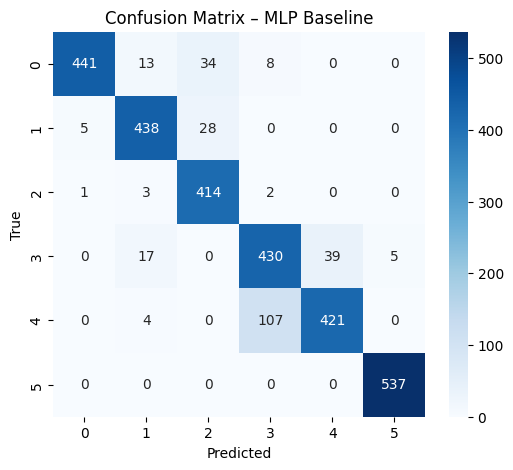

In [34]:
# evaluate trained model on test data
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model.eval()
# empty lists to collect preds and true labels
all_preds, all_true = [], [] # what model predicted, what correct labels actually were
# colect preds batch by batch then combine later

# disable gradient computation bc not training
with torch.no_grad():
    # loop through batches
    for xb, yb in test_loader:
      # get logits (how strongly model belives sample belongs to class) and highest score
        preds = torch.argmax(model(xb), dim=1)
        # convert pytorch tensor to numpy array and store in list
        all_preds.append(preds.numpy())
        # store corresponding true lables
        all_true.append(yb.numpy())

# combine all batches into one full vector
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("\nPer-class metrics:\n")
print(classification_report(y_true, y_pred, digits=3))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – MLP Baseline")
plt.show()

**Takeaways**  
- accuracy 90.97
- macro-f1 0.910
- weighted-f1 0.910
- correctly classifies about 91% of unseen activity windows from new subjects
- high F1 confirms performance consistently stssrong across all classes, isn't dominated by any
- generalizes well to new subjects
  
  **confusion matrix**
  - class 5 perfectly classified (distinct signal pattern easy to recognize)
  - most confusion between 3 and 4
  - class 0 sometimes confused with class 2
  - not random cnfusion but between specific pairs